In [ ]:
# keras相关包
from tensorflow.keras.applications import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# sklearn相关包
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.image import extract_patches_2d

import numpy as np
import cv2
import os
from imutils import paths
import progressbar

# 作图
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#设置随机种子
np.random.seed(161)

from keras.datasets import cifar10

#读取数据集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
train_classes, train_class_counts = np.unique(y_train, return_counts=True)
nb_train_classes = len(train_classes)
imbal_class_counts = [500, 1000] * 5

class_indices = [np.where(y_train == i)[0] for i in range(nb_train_classes)]

In [ ]:
imbal_class_indices = [class_idx[:class_count] for class_idx, class_count in zip(class_indices, imbal_class_counts)]
imbal_class_indices = np.hstack(imbal_class_indices)

y_train = y_train[imbal_class_indices]
x_train = x_train[imbal_class_indices]

In [ ]:
len(x_train)

7500

In [ ]:
from keras.utils.np_utils import to_categorical

# Y 热编码
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

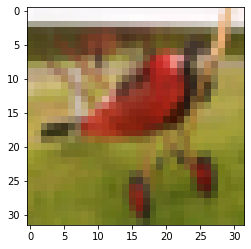

In [ ]:
plt.imshow(x_train[2])
plt.show()

In [ ]:
# 加载不包含top层的ResNet50作为baseModel
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(32, 32, 3)))

In [ ]:

def headmodel(baseModel):
    # 在baseModel基础上添加新的层
    headModel = baseModel.output
    
    # 新的 top 层
    headModel = Flatten()(headModel)
    headModel = Dense(10, activation="softmax")(headModel)

    return headModel

In [ ]:
headModel = headmodel(baseModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
#图片增广
# 首先利用ImageDataGenerator类实例化一个图像生成器对象，设置图片增广相关的参数。
aug00 = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [ ]:
# 保存模型快照的回调函数
modelname = "cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

In [ ]:
# 模型编译¶
# 编译模型需要指定优化器算法，loss函数和评估指标。之前的案例一直是二分类问题，所以loss函数使用的是binary_crossentropy，现在是多分类问题，loss函数使用categorical_crossentropy。

# 冻结住baseModel所有层的参数不学习
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# 编译
sgd = SGD(lr=0.01, decay=0.01 / 20, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# H = model.fit(x_train, y_train_oh, batch_size=32,
#                         validation_data=(x_test, y_test_oh),
#                         callbacks=[checkpoint],
#                         epochs=20)

H = model.fit_generator(aug00.flow(x_train, y_train_oh, batch_size=32),
                        validation_data=(x_test, y_test_oh),
                        callbacks=[checkpoint],
                        steps_per_epoch=len(x_train) // 32,
                        epochs=20)

Epoch 1/20
235/235 [==============================] - 76s 310ms/step - loss: 44.7736 - accuracy: 0.1215 - val_loss: 25.6737 - val_accuracy: 0.1873


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
235/235 [==============================] - 72s 307ms/step - loss: 27.9711 - accuracy: 0.1519 - val_loss: 26.2353 - val_accuracy: 0.1587
Epoch 3/20
235/235 [==============================] - 71s 303ms/step - loss: 18.4458 - accuracy: 0.1811 - val_loss: 11.3245 - val_accuracy: 0.2072
Epoch 4/20
235/235 [==============================] - 70s 299ms/step - loss: 15.7685 - accuracy: 0.1891 - val_loss: 15.2001 - val_accuracy: 0.1923
Epoch 5/20
235/235 [==============================] - 70s 299ms/step - loss: 11.8806 - accuracy: 0.2195 - val_loss: 18.0894 - val_accuracy: 0.2122
Epoch 6/20
235/235 [==============================] - 70s 298ms/step - loss: 10.1294 - accuracy: 0.2299 - val_loss: 12.3350 - val_accuracy: 0.2022
Epoch 7/20
235/235 [==============================] - 71s 304ms/step - loss: 7.7040 - accuracy: 0.2535 - val_loss: 9.1043 - val_accuracy: 0.2179
Epoch 8/20
235/235 [==============================] - 70s 300ms/step - loss: 7.1712 - accuracy: 0.2516 - val_loss: 10.05

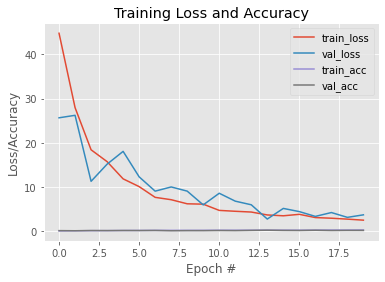

In [ ]:
# 绘制loss和accuracy曲线
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# 分类评估报告
preds = model.predict(x_test, batch_size=32)
print(classification_report(y_test_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))

#  target_names=labelNames

              precision    recall  f1-score   support

           0     0.6009    0.1370    0.2231      1000
           1     0.3590    0.5460    0.4332      1000
           2     0.3205    0.0250    0.0464      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.4242    0.0140    0.0271      1000
           5     0.6154    0.0160    0.0312      1000
           6     0.3636    0.0160    0.0307      1000
           7     0.1436    0.9460    0.2494      1000
           8     0.3885    0.5680    0.4614      1000
           9     0.8095    0.0170    0.0333      1000

    accuracy                         0.2285     10000
   macro avg     0.4025    0.2285    0.1536     10000
weighted avg     0.4025    0.2285    0.1536     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import sys
import io

In [ ]:
final_report = classification_report(y_test_oh.argmax(axis=1),preds.argmax(axis=1), digits=4)
report_pd = pd.read_csv(io.StringIO(final_report), delim_whitespace=True, error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
b'Skipping line 15: expected 5 fields, saw 6\nSkipping line 16: expected 5 fields, saw 6\n'


In [ ]:
report_re = report_pd[:10]
report_re = report_re.reset_index()
report_re = report_re[["index", "f1-score"]]
report_re.columns=['class_name','f1_score']

report_re['1-f1_score'] = 1-report_re['f1_score']
ds_sum = report_re['1-f1_score'].sum() 
report_re["class_weight"] = report_re["1-f1_score"]/ds_sum
report_re["re_class_counts"] = (report_re["1-f1_score"]/ds_sum)*len(x_train)

report_re["row_distribution"] = pd.DataFrame(imbal_class_counts)
report_re['tt'] = report_re['re_class_counts'] - report_re['row_distribution']
report_re.loc[report_re["tt"]<0,"tt"] = report_re["re_class_counts"]

report_re002 = report_re[["class_name","class_weight","re_class_counts","row_distribution","tt"]]
report_re002["tt"] = round(report_re002["tt"])
report_re002.columns=['class_name',"class_weight","re_class_counts","row_distribution","update_num"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
report_re002

,class_name,class_weight,re_class_counts,row_distribution,update_num
0,0,0.091787,688.399376,500,188.0
1,1,0.066964,502.232934,1000,502.0
2,2,0.112663,844.970582,500,345.0
3,3,0.118145,886.084922,1000,886.0
4,4,0.114943,862.072021,500,362.0
5,5,0.114459,858.439073,1000,858.0
6,6,0.114518,858.882115,500,359.0
7,7,0.088679,665.095343,1000,665.0
8,8,0.063633,477.245339,500,477.0
9,9,0.114210,856.578294,1000,857.0


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import random

In [ ]:
# choose images whose label is i
class_indices_0 = [np.where(y_train == 0)[0]]
x_train_0 = x_train[class_indices_0]

class_indices_1 = [np.where(y_train == 1)[0]]
x_train_1 = x_train[class_indices_1]

class_indices_2 = [np.where(y_train == 2)[0]]
x_train_2 = x_train[class_indices_2]

class_indices_3 = [np.where(y_train == 3)[0]]
x_train_3 = x_train[class_indices_3]

class_indices_4 = [np.where(y_train == 4)[0]]
x_train_4 = x_train[class_indices_4]

class_indices_5 = [np.where(y_train == 5)[0]]
x_train_5 = x_train[class_indices_5]

class_indices_6 = [np.where(y_train == 6)[0]]
x_train_6 = x_train[class_indices_6]

class_indices_7 = [np.where(y_train == 7)[0]]
x_train_7 = x_train[class_indices_7]

class_indices_8 = [np.where(y_train == 8)[0]]
x_train_8 = x_train[class_indices_8]

class_indices_9 = [np.where(y_train == 9)[0]]
x_train_9 = x_train[class_indices_9]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an ar

In [ ]:
report_re002

,class_name,class_weight,re_class_counts,row_distribution,update_num
0,0,0.091787,688.399376,500,188.0
1,1,0.066964,502.232934,1000,502.0
2,2,0.112663,844.970582,500,345.0
3,3,0.118145,886.084922,1000,886.0
4,4,0.114943,862.072021,500,362.0
5,5,0.114459,858.439073,1000,858.0
6,6,0.114518,858.882115,500,359.0
7,7,0.088679,665.095343,1000,665.0
8,8,0.063633,477.245339,500,477.0
9,9,0.114210,856.578294,1000,857.0


In [ ]:
report_re002['re_class_counts'].sum()

7500.0

In [ ]:
def data_augmentation(img, number):
  image = np.expand_dims(img, axis=0)
  # 实例化图像生成器类，指定一些常用的图片增广参数
  aug = ImageDataGenerator(rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1, 
                shear_range=0.2, 
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode="nearest")
    
  imageGen = aug.flow(image, batch_size=1)
  # aug.flow??

  total = 0
  imglist = []
  for x in imageGen:
    total += 1
    imglist.append(x)
    if total == number:
      break

  # imgback = np.array(imglist)
  return imglist

In [ ]:
def img_add(x_train_i, num):
  img_list = []
  for image in x_train_i:
    img_list_i = data_augmentation(image, 20)
    img_list.extend(img_list_i)
  
  imgback = random.sample(img_list, num)
  imgback = np.array(imgback)
  final_x_train_i = np.vstack((x_train_i,imgback.squeeze()))
  return final_x_train_i


In [ ]:
ds_change_0 = img_add(x_train_0, 188)
ds_change_1 = np.array(random.sample(list(x_train_1), 502))
ds_change_2 = img_add(x_train_2, 345)
ds_change_3 = np.array(random.sample(list(x_train_3), 886))
ds_change_4 = img_add(x_train_4, 362)
ds_change_5 = np.array(random.sample(list(x_train_5), 858))
ds_change_6 = img_add(x_train_6, 359)
ds_change_7 = np.array(random.sample(list(x_train_7), 665))
ds_change_8 = np.array(random.sample(list(x_train_8), 477))
ds_change_9 = np.array(random.sample(list(x_train_9), 857))

In [ ]:
x_train_new = np.vstack((ds_change_0,ds_change_1))
x_train_new = np.vstack((x_train_new,ds_change_2))
x_train_new = np.vstack((x_train_new,ds_change_3))
x_train_new = np.vstack((x_train_new,ds_change_4))
x_train_new = np.vstack((x_train_new,ds_change_5))
x_train_new = np.vstack((x_train_new,ds_change_6))
x_train_new = np.vstack((x_train_new,ds_change_7))
x_train_new = np.vstack((x_train_new,ds_change_8))
x_train_new = np.vstack((x_train_new,ds_change_9))

# plt.imshow(x_train_new[5])
# plt.show()

# len(x_train_new)

In [ ]:
def new_array(row,nmb):
  new_arr = np.zeros((row,1))
  for i in range(row):
    new_arr[i] = np.array([nmb])
  return new_arr

def change_y(update0,update1,update2,update3,update4,update5,update6,update7,update8,update9):
  y0 = new_array(update0,0)
  y1 = new_array(update1,1)
  y2 = new_array(update2,2)
  y3 = new_array(update3,3)
  y4 = new_array(update4,4)
  y5 = new_array(update5,5)
  y6 = new_array(update6,6)
  y7 = new_array(update7,7)
  y8 = new_array(update8,8)
  y9 = new_array(update9,9)

  y_train_new = np.vstack((y0,y1))
  y_train_new = np.vstack((y_train_new,y2))
  y_train_new = np.vstack((y_train_new,y3))
  y_train_new = np.vstack((y_train_new,y4))
  y_train_new = np.vstack((y_train_new,y5))
  y_train_new = np.vstack((y_train_new,y6))
  y_train_new = np.vstack((y_train_new,y7))
  y_train_new = np.vstack((y_train_new,y8))
  y_train_new = np.vstack((y_train_new,y9))
  
  y_train_new_oh = to_categorical(y_train_new)

  return y_train_new_oh

In [ ]:
y_train_new_oh = change_y(688,502,845,886,862,858,859,665,477,857)

In [ ]:
len(y_train_new_oh)

7499

In [ ]:
# 允许baseModel所有层的参数都可学习
for layer in baseModel.layers:
    layer.trainable = True

In [ ]:
# 保存模型快照的回调函数
modelname = "final_cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

In [ ]:
# 编译
sgd = SGD(lr=0.001, decay=0.001 / 20, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
H = model.fit_generator(aug00.flow(x_train_new, y_train_new_oh, batch_size=32),
                        validation_data=(x_test, y_test_oh),
                        callbacks=[checkpoint],
                        steps_per_epoch=len(x_train) // 32,
                        epochs=20)

# H = model.fit(x_train_new, y_train_new_oh, batch_size=32,
#                         validation_data=(x_test, y_test_oh),
#                         callbacks=[checkpoint],
#                         epochs=20)

In [ ]:

# 绘制loss和accuracy曲线
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# 分类评估报告
preds = model.predict(x_test, batch_size=32)
print(classification_report(y_test_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))